### Import the required packages

In [1]:
import requests
import os
import sys
from time import sleep
import json
import urllib2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wand.image import Image as WImage
%matplotlib inline

### Define required functions

In [2]:
def CheckResponse(r):
    status=str(r.status_code)
    if status == "200":
        #print "Finished"
        sys.stdout.flush()
    elif status == "201":
        sys.stdout.flush()
    else:
        print r, r.status_code
        sys.stdout.flush()
        
def checkCytoscapeVersion(host="localhost",port=1234):
    """
    Checks cytoscape version
    
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    
    :returns: cytoscape and api version
    """
    
    URL="http://"+str(host)+":"+str(port)+"/v1/version/"
    r = requests.get(url = URL)
    r=json.loads(r.content)
    for k in r.keys():
        print k, r[k]
        
def cytoscape(namespace,command="",PARAMS={},host="localhost",port=1234,method="POST",verbose=False):
    """
    General function for interacting with Cytoscape API.
    
    :param namespace: namespace where the request should be executed. eg. "string"
    :param commnand: command to execute. eg. "protein query"
    :param PARAMs: a dictionary with the parameters. Check your swagger normaly running on
    http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    :param method: type of http call, ie. "POST" or "GET" or "HELP".
    :param verbose: print more information
    
    :returns: For "POST" the data in the content's response. For "GET" None. 
    
    eg.

    cytoscape("G","string","pubmed query",{"pubmed":"p53 p21","limit":"50"})


    """     

    if (method == "GET") or (method == "G"):
        P=[]
        for p in PARAMS.keys():
            v=str(PARAMS[p])
            v=v.replace(" ","%20")  
            P.append(str(p)+"="+str(PARAMS[p]))
        P="&".join(P)
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)+"?"+P
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        r = requests.get(url = URL)
        CheckResponse(r)
        res=None
    
    elif (method == "POST") or (method == "P"):
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)
        r = requests.post(url = URL, json = PARAMS)
        CheckResponse(r)
        res=r.content
        if verbose:
            print res
        res=json.loads(res)
        res=res["data"]
        
    elif (method=="HTML") or (method == "H") or (method=="HELP"):
        P=[]
        for p in PARAMS.keys():
            v=str(PARAMS[p])
            v=v.replace(" ","%20")  
            P.append(str(p)+"="+str(PARAMS[p]))
        P="&".join(P)
        URL="http://"+str(host)+":"+str(port)+"/v1/commands/"+str(namespace)+"/"+str(command)+"?"+P
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        response = urllib2.urlopen(URL)
        #print response
        res = response.read()
        print res
        sys.stdout.flush()
    
    return res

def getTableColumns(table, columns, namespace = "default", network = "current", host="localhost",port=1234,verbose=False):
    """
    Gets tables from cytoscape
    
    :param table: table to retrieve eg. node
    :param columns: columns to retrieve
    :param namespace: namepsace, default="default"
    :param network: a network name or id, default="current"
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    :param verbose: print more information

    :returns: a pandas dataframe
    """
    
    
    if type(network) != int:
        network=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"SUID"})
        network=network[0]["SUID"]

    
    df=pd.DataFrame()
    def target(column):
        URL="http://"+str(host)+":"+str(port)+"/v1/networks/"+str(network)+"/tables/"+namespace+table+"/columns/"+column  
        if verbose:
            print "'"+URL+"'"
            sys.stdout.flush()
        response = urllib2.urlopen(URL)
        response = response.read()
        colA=json.loads(response)

        col=pd.DataFrame()    
        colHeader=colA["name"]
        colValues=colA["values"]
        col[colHeader]=colValues
        return col
    
    ncols=["name"]
    for c in columns:
        ncols.append(c.replace(" ","%20") )
    for c in ncols:
        col=target(c)
        df=pd.concat([df,col],axis=1)
        
    df.index=df["name"].tolist()
    df=df.drop(["name"],axis=1)
    
    return df

def loadTableData(df, df_key='index',table="node", \
                   table_key_column = "name",
                   network="current",\
                   namespace="default",\
                   host="localhost",port=1234,verbose=False):

    """
    Loads tables into cytoscape
    
    :param df: a pandas dataframe to load
    :param df_key: key column in df
    :param table: target table, default="node"
    :param table_key_column: table key column, default="name"
    :param network: a network name or id, default="current"
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    :param verbose: print more information

    :returns: output of put request
    """
    
    
    
    if type(network) != int:
        networkID=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"SUID"})
        networkname=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"name"})
        
        network=networkID[0]["SUID"]
        networkname=networkname[0]["name"]
        
    tmp=df.copy()
    if df_key!="index":
        tmp.index=tmp[df_key].tolist()
        tmp=tmp.drop([df_key],axis=1)
            
    tablen=networkname+" default node"
    
    data=[]
    
    for c in tmp.columns.tolist():
        tmpcol=tmp[[c]].dropna()
        for r in tmpcol.index.tolist():
            cell={}
            cell[str(table_key_column)]=str(r) # {"name":"p53"}
            val=tmpcol.loc[r,c]
            cell[str(c)]=val
            data.append(cell)
    
    
    upload={"key":table_key_column,"dataKey":table_key_column,\
            "data":data}
    
    
    URL="http://"+str(host)+":"+str(port)+"/v1/networks/"+str(network)+"/tables/"+namespace+table  
    if verbose:
        print "'"+URL+"'"
        sys.stdout.flush()
    r = requests.put(url = URL, json = upload)
    if verbose:
        print r
    CheckResponse(r)
    res=r.content
    return res

def simple_defaults(defaults_dic):
    """
    Simplifies defaults.
    
    :param defaults_dic: a dictionary of the form { visualProperty_A:value_A, visualProperty_B:value_B, ..}
    
    :returns: a list of dictionaries with each item corresponing to a given key in defaults_dic
    """
     
    defaults=[]
    for d in defaults_dic.keys():
        dic={}
        dic["visualProperty"]=d
        dic["value"]=defaults_dic[d]
        defaults.append(dic)
    return defaults
    
def update_style(title,defaults=None,mappings=None,host="localhost",port=1234):
    """
    Updates a visual style
    
    :param title: title of the visual style
    :param defaults: a list of dictionaries for each visualProperty
    :param mappings: a list of dictionaries for each visualProperty
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    
    :retunrs: nothing
    """
        
    URL="http://"+str(host)+":"+str(port)+"/v1/styles/"+str(title)
    response = urllib2.urlopen(URL)    
    response = response.read()
    response = json.loads(response)
    
    olddefaults=response["defaults"]
    oldmappings=response["mappings"]

    if mappings:
        mappings_visual_properties=[ m["visualProperty"] for m in mappings ]
        newmappings=[ m for m in oldmappings if m["visualProperty"] not in mappings_visual_properties ]
        for m in mappings:
            newmappings.append(m)
    else:
        newmappings=oldmappings

    if defaults:
        defaults_visual_properties=[ m["visualProperty"] for m in defaults ]
        newdefaults=[ m for m in olddefaults if m["visualProperty"] not in defaults_visual_properties ]
        for m in defaults:
            newdefaults.append(m)
    else:
        newdefaults=olddefaults
        
    r=requests.delete(URL)
    CheckResponse(r)    

    URL="http://"+str(host)+":"+str(port)+"/v1/styles"
    PARAMS={"title":title,\
           "defaults":newdefaults,\
           "mappings":newmappings}
    r = requests.post(url = URL, json = PARAMS)
    CheckResponse(r)
    
def create_styles(title,defaults=None,mappings=None,host="localhost",port=1234):
    """
    Creates a new visual style
    
    :param title: title of the visual style
    :param defaults: a list of dictionaries for each visualProperty
    :param mappings: a list of dictionaries for each visualProperty
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    
    :retunrs: nothing
    """   
    
    try:
        update_style(title,defaults=defaults,mappings=mappings,host=host,port=port)
        print "Existing style was updated."
        sys.stdout.flush()
    except:
        print "Creating new style."
        sys.stdout.flush()
        URL="http://"+str(host)+":"+str(port)+"/v1/styles"
        PARAMS={"title":title,\
               "defaults":defaults,\
               "mappings":mappings}
        r = requests.post(url = URL, json = PARAMS)
        CheckResponse(r)

    
def mapVisualProperty(visualProperty,mappingType,mappingColumn,\
                      lower=None,center=None,upper=None,\
                      discrete=None,\
                      network="current",table="node",\
                      namespace="default",host="localhost",\
                      port=1234):
    """"
    Generates a dictionary for a given visual property
    
    :param visualProperty: visualProperty
    :param mappingType: mappingType
    :param mappingColumn: mappingColumn
    :param lower: for "continuous" mappings a list of the form [value,rgb_string]
    :param center: for "continuous" mappings a list of the form [value,rgb_string]
    :param upper: for "continuous" mappings a list of the form [value,rgb_string]
    :param discrete: for discrete mappings, a list of lists of the form [ list_of_keys, list_of_values ]
    :param network: a network name or id, default="current"
    :param host: cytoscape host address, default="localhost"
    :param port: cytoscape port, default=1234
    
    :retunrs: a dictionary for the respective visual property

    """
    if type(network) != int:
        networkID=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"SUID"})
        networkname=cytoscape("network", "get attribute",\
                      {"network":network,\
                       "namespace":namespace,\
                       "columnList":"name"})
        
        network=networkID[0]["SUID"]
        networkname=networkname[0]["name"]

        URL="http://"+str(host)+":"+str(port)+"/v1/networks/"+str(network)+"/tables/"+namespace+table+"/columns/"
        response = urllib2.urlopen(URL)
        response = response.read()
        response = json.loads(response)

    for r in response:
        if r["name"]==mappingColumn:
            mappingColumnType=r["type"]
            break
            
    PARAMS={"mappingType" : mappingType,\
            "mappingColumn" : mappingColumn,
            "mappingColumnType" : mappingColumnType,
            "visualProperty" : visualProperty}
    if mappingType == "continuous":
        PARAMS["points"]=[{"value" : lower[0],\
                           "lesser" : lower[1],\
                           "equal" : lower[1],\
                           "greater" : lower[1]},\
                          {"value" : center[0],
                           "lesser" : center[1],
                           "equal" : center[1],
                           "greater" : center[1] },\
                          {"value" : upper[0],\
                           "lesser" : upper[1],\
                           "equal" : upper[1],\
                           "greater" : upper[1]}]
        
    if discrete:
        PARAMS["map"]=[]
        for k,v in zip(discrete[0],discrete[1]):
            PARAMS["map"]=PARAMS["map"].append({ "key":k,"value":v})

    return PARAMS

def result(outfile=None):
    """
    Checks the current network. 
    
    Note: works only on localhost
    
    :param outfile: name of the temporary outfile
    
    :returns: nothing
    """
    sleep(1)
    if not outfile:
        outfile=os.getcwd()+"/tmp"
    response=cytoscape("view","fit content")
    response=cytoscape("view", "export" , \
                       {"options":"PNG",\
                        "OutputFile":outfile})
    img = WImage(filename=outfile+".png")
    os.remove(outfile+".png")
    return img

### Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the STRING app, if you haven't already: http://apps.cytoscape.org/apps/stringapp
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

In [3]:
checkCytoscapeVersion()

cytoscapeVersion 3.6.0
apiVersion v1


cleanse the palette before importing new networks and styles

In [4]:
response=cytoscape("vizmap", "apply",{"styles":"default"})

################################################
# Step 1: Getting Disease Networks
################################################

Use Cytoscape to query the STRING database for networks of genes associated with breast cancer and ovarian cancer.

**If the STRING app is not installed, no error is reported, but your network  will be empty**

### Query STRING database by disease to generate networks

#### Breast cancer

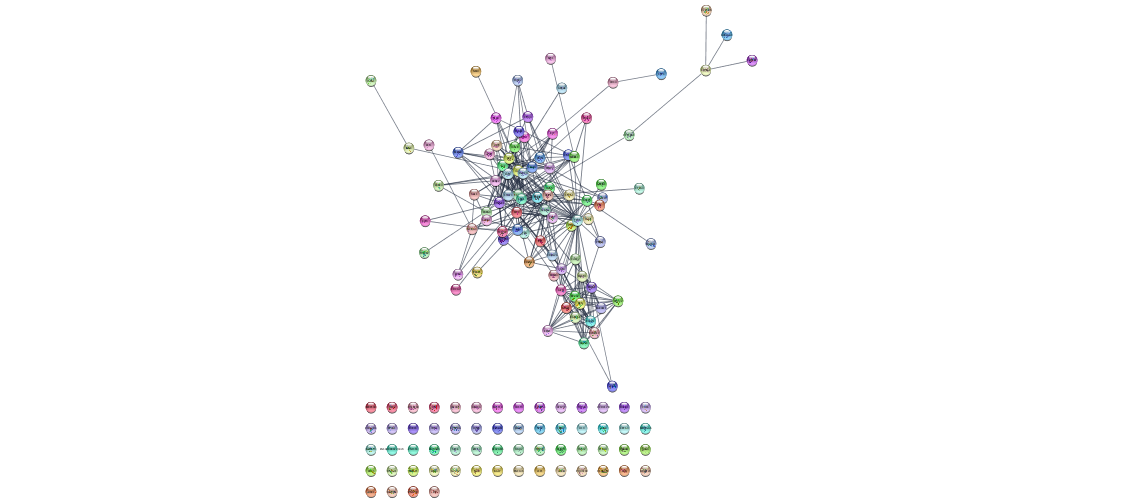

In [5]:
response=cytoscape("string", "disease query",\
                  {"disease":"breast cancer",\
                   "cutoff":"0.9",\
                   "species":"Homo sapiens",\
                   "limit":"150"})
sleep(1)
result()

Here we are using Cytoscape's command line syntax, converting it to a CyREST url, and then making a PUT request. 

#### Ovarian cancer

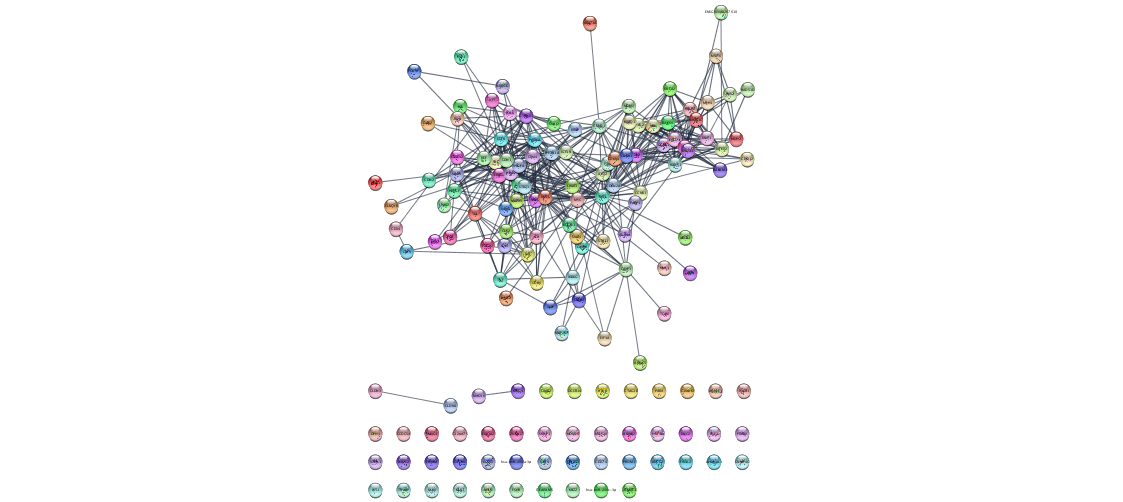

In [6]:
response=cytoscape("string", "disease query",\
                  {"disease":"ovarian cancer",\
                   "cutoff":"0.9",\
                   "species":"Homo sapiens",\
                   "limit":"150"})
result()

################################################
# Step 2: Interacting with Cytoscape 
################################################

Now that we've got a couple networks into Cytoscape, let's see what we can go with them from R...

### Get list of networks 

In [7]:
response=cytoscape("network", "list")
print response

[52, 1146]


### Layout network

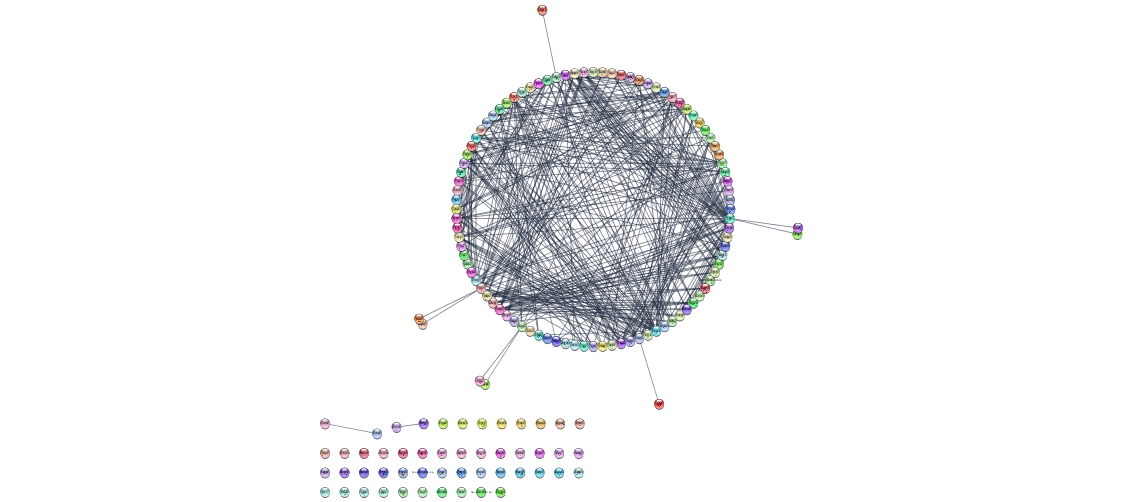

In [8]:
response=cytoscape("layout", "circular")
result()

#### List of layout algorithms available

In [9]:
response=cytoscape("layout",method="HELP",verbose=True)

'http://localhost:1234/v1/commands/layout/?'
<p style="color:blue;margin-top:0px;margin-bottom:5px;">Available commands for 'layout':</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  apply preferred</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  attribute-circle</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  attributes-layout</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  circular</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  copycat</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  cose</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  degree-circle</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  force-directed</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  force-directed-cl</p>
<p style="color:black;

#### Layout with parameters!

In [10]:
response=cytoscape("layout", "force-directed",\
                  {"defaultSpringCoefficient":".000004",\
                   "defaultSpringLength":"5"})

In [11]:
response=cytoscape("layout","force-directed",method="HELP")

<p style="color:blue;margin-top:0px;margin-bottom:5px;">Available arguments for 'layout force-directed':</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  defaultEdgeWeight</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  defaultNodeMass</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  defaultSpringCoefficient</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  defaultSpringLength</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  EdgeAttribute</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  isDeterministic</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  maxWeightCutoff</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  minWeightCutoff</p>
<p style="color:black;margin-left:10px;margin-top:0px;margin-bottom:5px;">  network</p>
<p style="color:black;

These *command* calls will allow you to interrogate the layouts and parameters available in your active Cytoscape session. This includes any layouts added by apps you've installed!

### Get table data from network
Now, let's look at the tablular data associated with our STRING networks...

In [12]:
response=cytoscape("node","list attributes",\
                   {"network":"current",\
                   "namespace":"default"} )
print response

[u'SUID', u'shared name', u'name', u'selected', u'canonical name', u'display name', u'full name', u'database identifier', u'description', u'@id', u'namespace', u'node type', u'query term', u'sequence', u'species', u'STRING style', u'enhancedLabel Passthrough', u'canonical', u'compartment chloroplast', u'compartment cytoskeleton', u'compartment cytosol', u'compartment endoplasmic reticulum', u'compartment endosome', u'compartment extracellular', u'compartment golgi apparatus', u'compartment lysosome', u'compartment mitochondrion', u'compartment nucleus', u'compartment peroxisome', u'compartment plasma membrane', u'compartment vacuole', u'image', u'target development level', u'target family', u'tissue adrenal gland', u'tissue blood', u'tissue bone', u'tissue bone marrow', u'tissue eye', u'tissue gall bladder', u'tissue heart', u'tissue intestine', u'tissue kidney', u'tissue liver', u'tissue lung', u'tissue lymph node', u'tissue muscle', u'tissue nervous system', u'tissue pancreas', u'tis

One of the great things about the STRING database is all the node and edge attriubtes they provide. Let's pull some of it into R to play with...

#### Retrieve disease scores 
We can retrieve any set of columns from Cytoscape and store them as an R data frame.

In [13]:
disease_score_table=getTableColumns('node',['disease score'])
disease_score_table.head()

,disease score
9606.ENSP00000350941,1.852458
9606.ENSP00000332049,1.747818
9606.ENSP00000398880,1.637925
9606.ENSP00000332602,1.708656
9606.ENSP00000265433,5.000000


#### Plot distribution and pick threshold
Now you can use python like you normally would explore the data.

Text(0,0.5,u'frequency')

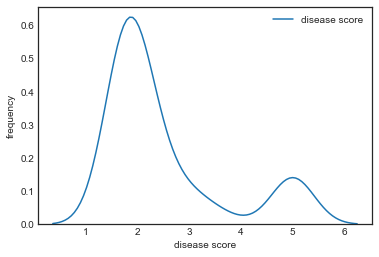

In [14]:
sns.set_style("white")
sns.kdeplot( disease_score_table["disease score"] )
plt.xlabel("disease score")
plt.ylabel("frequency")

### Generate subnetworks
In order to reflect your exploration back onto the network, let's generate subnetworks...

...from top quartile of 'disease score'

In [15]:
top_quart=disease_score_table[["disease score"]].quantile(0.75)[0]
top_nodes=disease_score_table[disease_score_table["disease score"]>top_quart].index.tolist()

In [16]:
values="name:"+",".join(top_nodes)
response=cytoscape("network","create",
                   {"source":"current",\
                    "excludeEdges":"false",\
                    "nodeList":values})
response=cytoscape("network","rename",\
                   {"name":'top disease quartile'})

...of connected nodes only

In [17]:
response=cytoscape("network","create",
                   {"source":"current",\
                    "edgeList":"all",\
                    "nodeList":"selected"})

...from first neighbors of top 3 genes, using the network connectivity together with the data to direct discovery.

In [18]:
response=cytoscape("network","set current",
                   {"network":"String Network - ovarian cancer"})

In [19]:
top_nodes=disease_score_table.sort_values(by=["disease score"],\
                                         ascending=False)
top_nodes=top_nodes.index.tolist()[:3]
print top_nodes

[u'9606.ENSP00000269305', u'9606.ENSP00000233146', u'9606.ENSP00000336701']


In [20]:
response=cytoscape("network","select",
                   {"nodeList":"name:"+",".join(top_nodes)})

In [21]:
response=cytoscape("network","select",
                   {"firstNeighbors":"",\
                    "direction":"any",\
                    "network":"current"})

In [22]:
response=cytoscape("network","create",
                   {"source":"current",\
                    "nodeList":"selected"})

In [23]:
response=cytoscape("network","rename",\
                   {"name":'top disease neighbors'})

...from diffusion algorithm starting with top 3 genes, using the network connectivity in a more subtle way than just first-degree neighbors.

In [24]:
print "ok"

ok


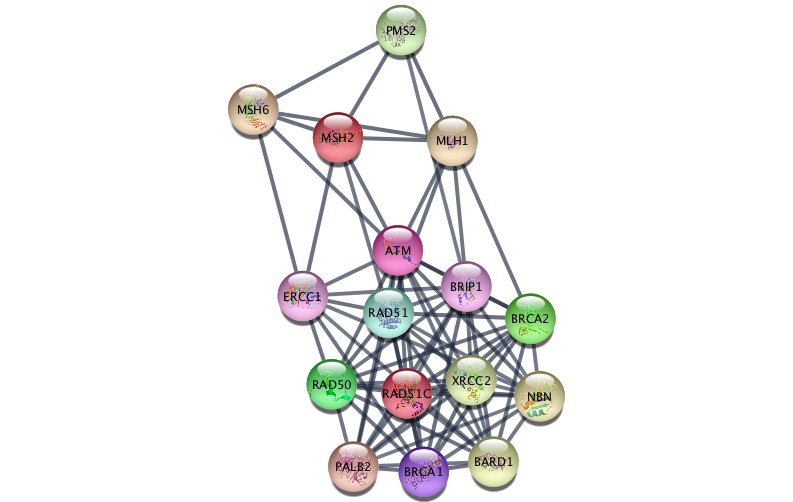

In [25]:
response=cytoscape("network","set current",
                   {"network":"String Network - ovarian cancer"})
response=cytoscape("network","select",
                   {"nodeList":"name:"+",".join(top_nodes)})
response=cytoscape("diffusion","diffuse")
response=cytoscape("network","create",
                   {"source":"current",\
                    "nodeList":"selected"})
response=cytoscape("layout", "force-directed")
response=cytoscape("network","rename",\
                   {"name":'top disease diffusion'})
result()

################################################
# Step 3: Visualizing data on networks
################################################

### Load datasets
Downloaded TCGA data from https://portal.gdc.cancer.gov/ and preprocessed as R objects. Also available via each TCGA publication, e.g.:
 
* Breast: https://tcga-data.nci.nih.gov/docs/publications/brca_2012/
* Ovarian: https://tcga-data.nci.nih.gov/docs/publications/ov_2011/

In [26]:
brc_expr=pd.read_table("data/brc.exp.tsv")
brc_mut=pd.read_table("data/brc.mut.tsv")

### Breast Cancer Datset
These datasets are similar to the data frames you normarlly encounter in R. For diversity, one using row.names to store corresponding gene names and the other uses the first column. Both are easy to import into Cytoscape.

In [27]:
brc_expr.head()

,expr.mean
ELMO2,-0.000167
CREB3L1,-0.005408
RPS11,0.018381
PNMA1,-0.065037
MMP2,-0.074444


In [28]:
brc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
13,A1CF,2,2
14,A2BP1,3,3
15,A2M,3,2
16,A2ML1,4,4
17,A4GALT,1,0


Let's return to the Breast Cancer network...

In [29]:
response=cytoscape("network","set current",
                   {"network":"String Network - breast cancer"})
response=cytoscape("layout", "force-directed",\
                   {"defaultSpringCoefficient":".000004",\
                   "defaultSpringLength":"5"})

...and use the helper function from r2cytoscape called *loadTableData*


In [30]:
response=loadTableData(brc_expr,table_key_column="display name")
response=loadTableData(brc_mut,df_key='Hugo_Symbol',table_key_column="display name")

#### Visual styles
Let's create a new style to visualize our imported data
...starting with the basics, we will specify a few defaults and obvious mappings in a custom style all our own.

In [31]:
defaults_dic={"NODE_SHAPE":"ellipse",\
               "NODE_SIZE":"60",\
               "NODE_FILL_COLOR":"#AAAAAA",\
               "EDGE_TRANSPARENCY":"120"}
defaults_list=simple_defaults(defaults_dic)

NODE_LABEL=mapVisualProperty("NODE_LABEL","passthrough","display name")

create_styles("dataStyle",defaults_list,[NODE_LABEL])
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})

Creating new style.


Now let's update the style with a mapping for mean expression. The first step is to grab the column data from Cytoscape and pull out the min and max to define our data mapping range of values.

In [32]:
brc_expr_network = getTableColumns('node',['expr.mean'])

In [33]:
min_brc_expr = min(brc_expr_network.dropna()['expr.mean'].tolist())
max_brc_expr = max(brc_expr_network.dropna()['expr.mean'].tolist())

min_brc_expr=abs(min_brc_expr)
max_brc_expr=abs(max_brc_expr)

max_brc_expr=max([min_brc_expr,max_brc_expr])
min_brc_expr=max_brc_expr*-1.0

In python we check matplotlib's color maps to help us pick good colors to pair with our data values: https://matplotlib.org/examples/color/colormaps_reference.html

In [34]:
cmap = matplotlib.cm.get_cmap("bwr")
norm = matplotlib.colors.Normalize(vmin=min_brc_expr, vmax=max_brc_expr)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_expr)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(0)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_expr)))  

print min_color, center_color, max_color

#0000ff #fffefe #ff0000


Finally, we use the handy *mapVisualProperty* function to construct the data object that CyREST needs to specify style mappings and then we'll send them off to Cytoscape with *updateStyleMappings*.

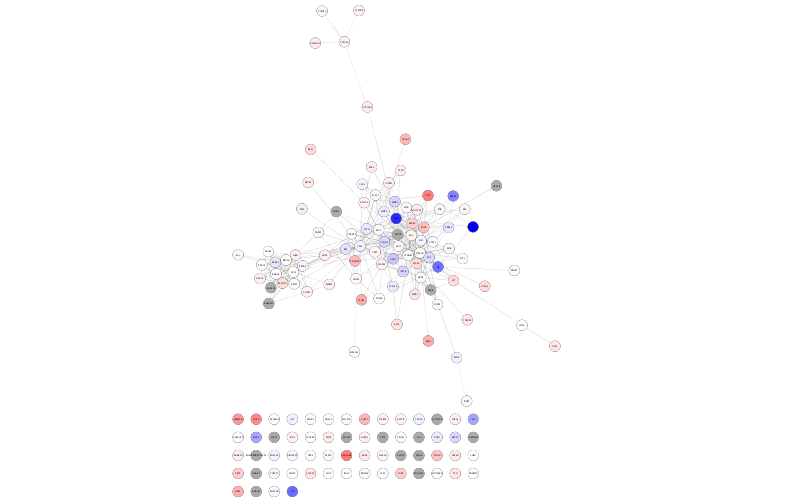

In [35]:
NODE_FILL_COLOR=mapVisualProperty('NODE_FILL_COLOR','continuous','expr.mean',\
                     lower=[min_brc_expr,min_color],center=[0.0,center_color],upper=[max_brc_expr,max_color])
update_style("dataStyle",mappings=[NODE_FILL_COLOR])
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})
result()

**Pro-tip: depending on your data, it may be better to balance your color range over negative and positive values bounded by the largest min or max data value, so that color intensity scales similarly in both directions.**

#### Visualize mutation data
OK, now let's update with a mapping for mutation. Here are all the same steps, but this time mapping mutation counts to *both* node border width and color. 

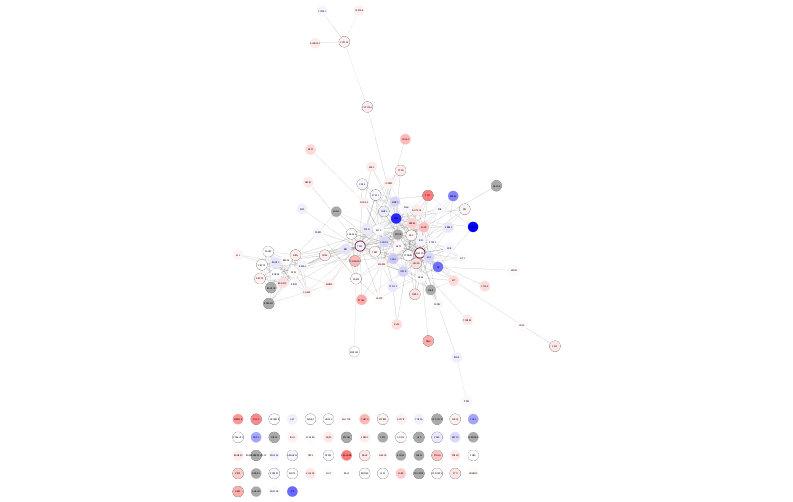

In [36]:
brc_mut_network = getTableColumns('node',['mut_count'])
min_brc_mut = min(brc_mut_network.dropna()['mut_count'].tolist())
max_brc_mut = max(brc_mut_network.dropna()['mut_count'].tolist())

cent_brc_mut=20.0

cmap = matplotlib.cm.get_cmap("Reds")
norm = matplotlib.colors.Normalize(vmin=min_brc_mut, vmax=max_brc_mut)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_mut)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(cent_brc_mut)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_mut)))  

NODE_BORDER_PAINT=mapVisualProperty('NODE_BORDER_PAINT','continuous','mut_count',\
                     lower=[min_brc_mut,min_color],center=[20,center_color],upper=[max_brc_mut,max_color])
update_style("dataStyle",mappings=[NODE_BORDER_PAINT])
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})

NODE_BORDER_WIDTH=mapVisualProperty('NODE_BORDER_WIDTH','continuous','mut_count',\
                     lower=[min_brc_mut,2],center=[20,4],upper=[max_brc_mut,8])
update_style("dataStyle",mappings=[NODE_BORDER_WIDTH])
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})
result()

#### Subnetwork based on diffusion from heavily mutated nodes
Now, let's pull in what we learned about subnetwork selection and apply it here...

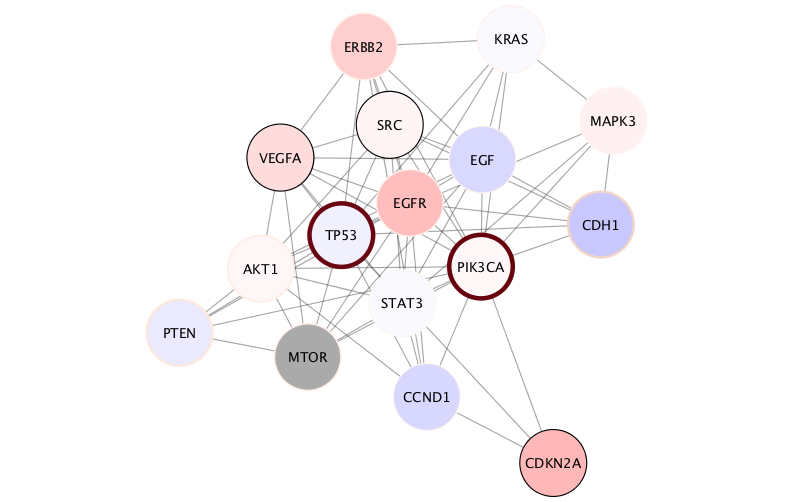

In [37]:
top_mut=brc_mut_network.dropna().sort_values(by=["mut_count"],ascending=False)
top_mut=top_mut.index.tolist()[:2]
response=cytoscape("network","select",
                   {"nodeList":"name:"+",".join(top_mut)})
response=cytoscape("diffusion","diffuse")
response=cytoscape("network","create",
                   {"source":"current",\
                    "nodeList":"selected"})
response=cytoscape("layout", "force-directed")
response=cytoscape("network","rename",\
                   {"name":'top mutated diffusion'})
result()

The top mutated genes are based on TCGA data and the diffusion algorithm is operating based on the network connectivity from STRING data, leading to a focused subnetwork view of critical Breast Cancer genes with mean patient expression data mapped to fill color. Now *that's* data integration!

**Pro-tip: You can generate a legend for this in Cytoscape Style tab > Options > Create style...  This is no yet available as a command. Coming soon!**


### Ovarian Cancer Datset
But what about the other network and datasets? Do we have to repeat *all* of those steps again?  Actually, no!

First, let's switch back over to the Ovarian Cancer network and load our data.

In [38]:
ovc_expr=pd.read_table("data/ovc.expr.tsv")
ovc_mut=pd.read_table("data/ovc.mut.tsv")

In [39]:
response=cytoscape("network","set current",
                   {"network":"String Network - ovarian cancer"})
response=loadTableData(ovc_expr,table_key_column="display name")
response=loadTableData(ovc_mut,df_key='Hugo_Symbol',table_key_column="display name")

**Because we used the same column names in our original data frames, now we can simply apply the *same* visual style created above!**

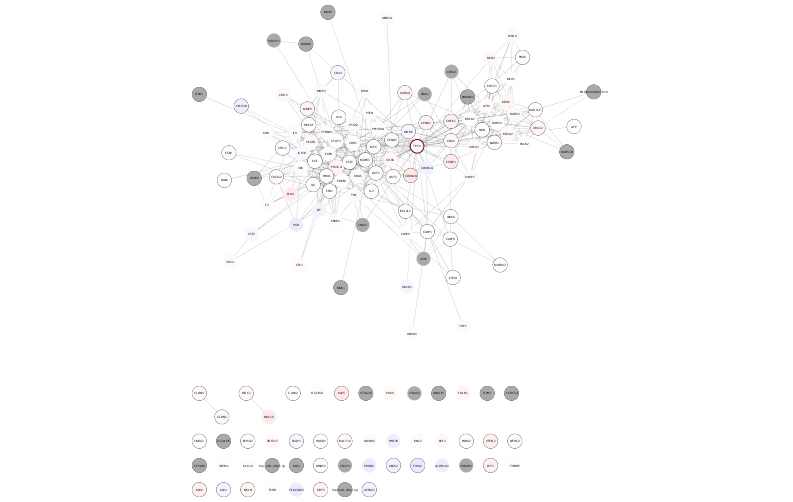

In [40]:
response=cytoscape("vizmap", "apply", {"styles":"dataStyle"})
response=cytoscape("network","deselect",{"nodeList":"all","edgeList":"all"})
sleep(1)
result()

Reusing the same style for both breast and ovarian cancers, we can compare the relative expression and mutation counts across the two datasets. 
For example, notice in the case of ovarian cancer: **decreased** range of mean expression and **fewer** mega-mutated genes.

##########################################
# Step 4: Saving, sharing and publishing
##########################################

### Saving a Cytoscape session file
Session files save *everything*. As with most project software, we recommend saving often!

In [41]:
response=cytoscape("session", "save as" , \
                   {"file":"cytoscape"})

**Note: If you don't specify a complete path, the files will be save relative to your Cytoscape installation directory, e.g., /Applications/Cytoscape_v3.6.0/... or somewhere you don't have write permissions. So, it's probably better to specify one...**

### Exporting high resolution image files
You can export extremely high resolution images, including vector graphic formats.

In [42]:
response=cytoscape("network","deselect",{"edgeList":"all"})
response=cytoscape("view","fit content")
response=cytoscape("view", "export" , \
                   {"options":"PDF",\
                    "OutputFile":"cytoscape_image"})

### Exporting interactive web pages via cytoscape.js
You can export the network model in multiple standard formats. And if you want to get really fancy, you can export the model and style in cytoscape.js formats and host interactive views of your network analysis and visualization results online!

In [43]:
response=cytoscape("network", "export" , \
                   {"options":'CYJS',\
                    "OutputFile":"cytoscape_network"})

response=cytoscape("vizmap", "export" , \
                   {"options":'json',\
                    "OutputFile":"cytoscape_style"})

More details in Cytoscape manual chapter on [Interactive Web Applications](http://manual.cytoscape.org/en/stable/Export_Your_Data.html#as-an-interactive-web-application-new-in-3-2-0)


And in Cytoscape, you can File>Export as Web Page... to produce a folder of cytoscape.js files and html.


### Additional network analysis and visualization options
* Mapping edge attributes to edge thickness, color and/or transparency (e.g., score or experiments) 
    * EDGE_WIDTH, EDGE_COLOR, EDGE TRANSPARENCY
* Edge bundling
    * bundleEdges()
* Directional edge animation
    * applyStyle('Marquee')
    * updateStyleDefaults(style.name,list('Edge Line Type'='Marquee_Dash'))
* Visualize two or more datasets as split-fill or pie chart, or patient-specific data as radial Circos plot
    * pending support for charts...
* Merge two (or more) networks
    * copyCytoscapeNetwork() or 'network clone'; then addGraphToGraph() (Union only)
    * using igraph: intersection(g1,g2), union(), difference(); followed by toCytoscape() and send2cy()

## swagger
http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json#/

##########################################
# Step 5: Wrapping up
##########################################

You should now know how to...

* Connect to Cytoscape from R
* Retrieve disease networks from STRING
* Interact with Cytoscape via commands, CyREST, and r2cytoscape
* Load various data types onto networks
* Set visual style defaults and mappings
* Perform selection and create subnetworks
* Save, share and publish your networks
* Find more information on Cytoscape automation

#### Resources
* Growing collection of [cytoscape automation resources](https://github.com/cytoscape/cytoscape-automation/), including **this** tutorial
* Growing collection of [cytoscape tutorial materials](https://github.com/cytoscape/cytoscape-tutorials)
* Active community on [cytoscape-helpdesk](https://groups.google.com/forum/#!forum/cytoscape-helpdesk) for any Cytoscape related questions and suggestions